# TIME SERIES ANALYSIS (ARIMA)

## Creating Time Series

### Loading and Handling Time Series in Pandas
Pandas has dedicated libraries for handling TS objects, particularly the datatime64[ns] class which stores time information and allows us to perform some operations really fast. Lets start by firing up the required libraries:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from datetime import datetime
import statsmodels.api as sm

In [2]:
os.chdir('C:\\Users\\tanuja.das\\Desktop\\time-series-air-passengers-master\\time-series-air-passengers-master')

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# Initial Inferences( Loading and Handling TS Data)

In [4]:
data = pd.read_csv('AirPassengers.csv')
data.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [5]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [8]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

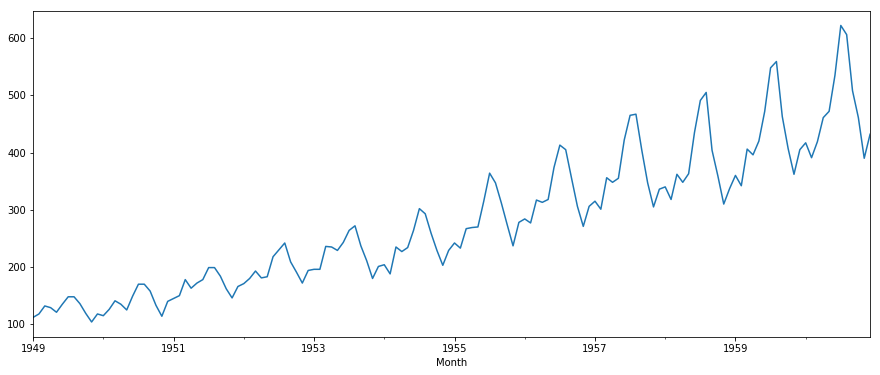

In [9]:
ts.plot()

## Outlier Treatment

In [10]:
#Data Summary
print("Min :",ts.min())
print("2% Quantile: ",ts.quantile(0.02))
print("4% Quantile: ",ts.quantile(0.04))
print("5% Quantile: ",ts.quantile(0.05))
print("10% Quantile: ",ts.quantile(0.10))
print("25% Quantile: ",ts.quantile(0.25))
print("50% Quantile: ",ts.quantile(0.50))
print("75% Quantile: ",ts.quantile(0.75))
print("90% Quantile: ",ts.quantile(0.90))
print("95% Quantile: ",ts.quantile(0.95))
print("98% Quantile: ",ts.quantile(0.98))
print("99% Quantile: ",ts.quantile(0.99))
print("Max: ",ts.max())
print("Mean: ",ts.mean())
print("Median: ",ts.median())
print("Mode: ",ts.mode())

Min : 104
2% Quantile:  114.86000000000001
4% Quantile:  118.72
5% Quantile:  121.6
10% Quantile:  135.3
25% Quantile:  180.0
50% Quantile:  265.5
75% Quantile:  360.5
90% Quantile:  453.2000000000005
95% Quantile:  488.14999999999986
98% Quantile:  549.5399999999998
99% Quantile:  585.7899999999997
Max:  622
Mean:  280.2986111111111
Median:  265.5
Mode:  0    229
dtype: int64


In [68]:
#ts=ts.clip_lower(ts.quantile(0.25)).clip_upper(ts.quantile(0.95))
#ts.plot()

Qutlier is not present in this data

# Testing Stationarity

 Dickey Fuller Test (Statistical Method)

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def augmented_dickey_fuller(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [13]:
augmented_dickey_fuller(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

If the Test Statistic is less than the Critical Value, we can say that the series is stationary.

Inferences: Test Statistic value way greater than the Critical values (Check signed values not absolute values)

# Procedure Overview

Time series models assume data is stationary which is rarely the case. So, we first have to make the series stationary. The factors making a time series non-stationary are:

1. Trend: Increasing Average with time
2. Seasonality: Variation in values during specific months

Procedure:

1. Estimate Trend and Seasonality
2. Eliminate both and make the series stationary
3. Apply time series models on the stationary data to forecast future values
4. Restore the trend and seasonality constraints to the forecasted values to convert to the original scale

# Trend Elimination by Model Estimation

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

## Transformation

Trend Type: Increasing Average.
We can use a transformation that penalize higher values more like log or sqrt

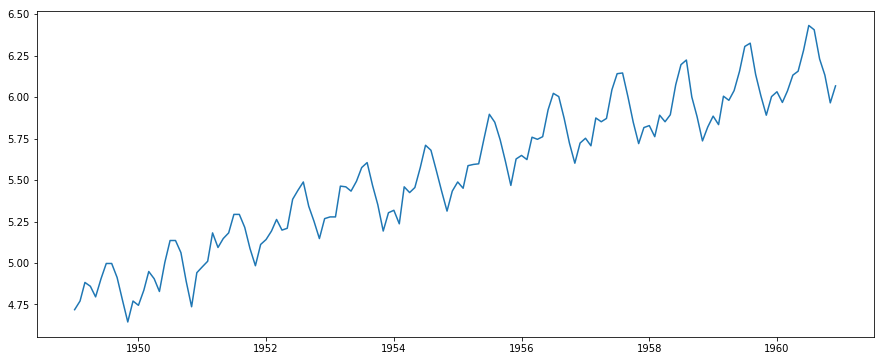

In [14]:
ts_log = np.log(ts)
plt.plot(ts_log)

The scale reduces, but the layout is still noisy. To estimate/model this trend and then remove it from the series would be a better approach. The possible methods are:

1. Aggregation – Average for a time period like monthly/weekly averages
2. Smoothing – Rolling Average
3. Polynomial Fitting – Fit a regression model

We will try out the Smoothing method by calculating the rolling average.

## Moving Average

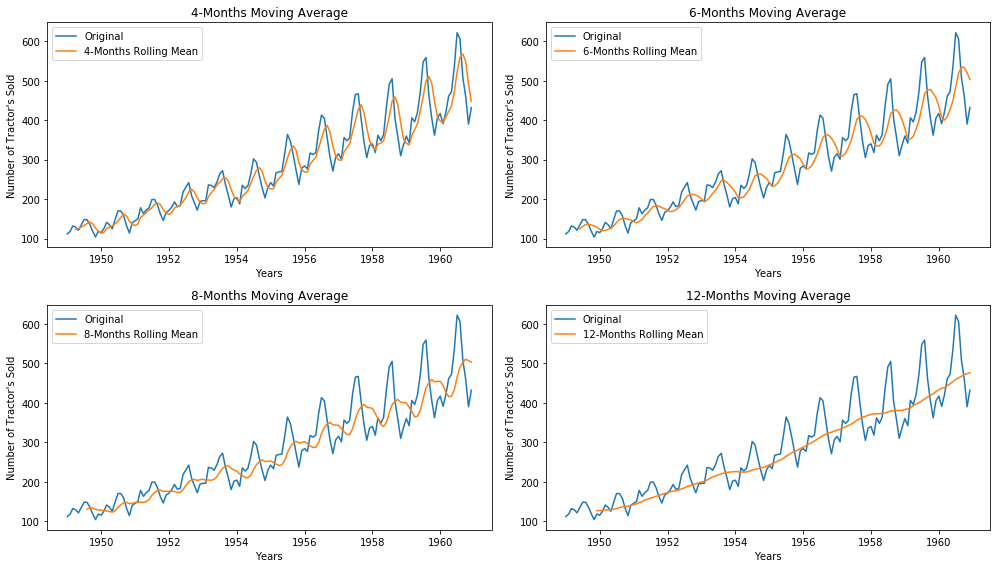

In [15]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(ts.index, ts, label='Original')
axes[0][0].plot(ts.index, ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(ts.index, ts, label='Original')
axes[0][1].plot(ts.index, ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(ts.index, ts, label='Original')
axes[1][0].plot(ts.index, ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(ts.index, ts, label='Original')
axes[1][1].plot(ts.index, ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

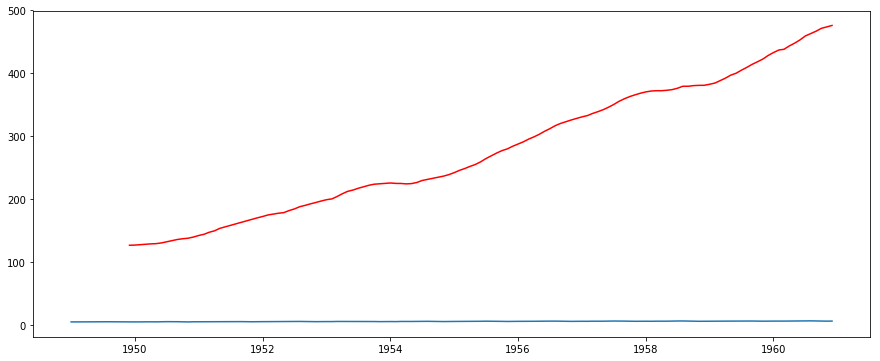

In [16]:
moving_avg = ts.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

Subtract the rolling average from the time series to reduce the trend.<br/>

Note: There are no values for the first 11 values as the window is of 12 months

In [17]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01   -121.895982
Name: #Passengers, dtype: float64

In [18]:
ts_log_moving_avg_diff.dropna(inplace=True)

In [19]:
augmented_dickey_fuller(ts_log_moving_avg_diff)

Test Statistic                   0.830404
p-value                          0.992111
#Lags Used                       2.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

This looks like a better time series. The test statistic is lesser than the 5% critical value, so we can say that the series is stationary with 95% confidence.

The drawback with this method is that one has to strictly specify a time frame for averaging. Here, we've taken it to be 1 year (12 months) but in complex cases, it's difficult to come up with a particular number.

## Exponential Weighted Moving Average

Therefore, we use Exponentially Weighted Moving Average (EMWA) where weights are assigned to all the previous values with a decay factor. More emphasis is given to recent past values and importance decreases for the older values.

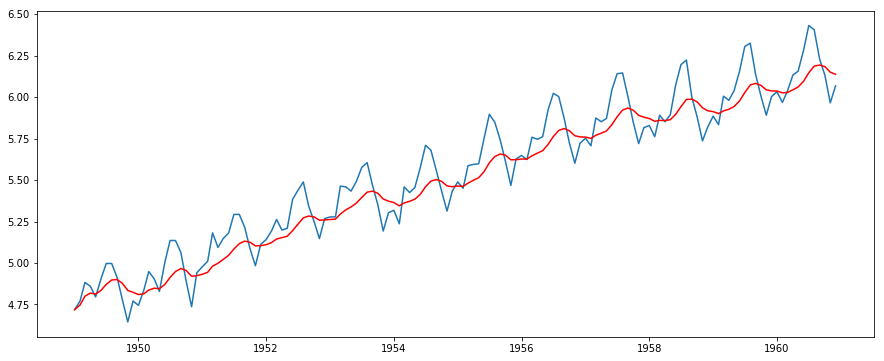

In [20]:
expweighted_avg = ts_log.ewm(span=12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

In [21]:
ts_log_ewma_diff = ts_log - expweighted_avg

In [22]:
augmented_dickey_fuller(ts_log_ewma_diff)

Test Statistic                  -3.310542
p-value                          0.014414
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

This time, it can be said that the series is stationary with 99% confidence which is better than the previous case. All the values are assigned weights therefore there are no missing values.

# Seasonality Elimination

The simple trend reduction techniques used above do not work in all cases, especially when the seasonality is high. There are better methods to counter seasonality:

1. Differencing: Taking the differece with a particular time lag
2. Decomposition: Modeling both Trend and Seasonality and removing them from the model.

## Differencing

We take the difference of the observation at a particular instant with that at the previous instant. First order differencing:

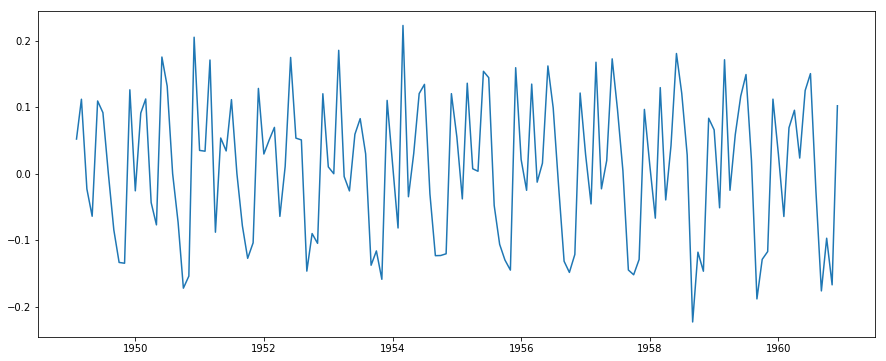

In [23]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [24]:
ts_log_diff.dropna(inplace=True)

In [25]:
augmented_dickey_fuller(ts_log_diff)

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

We can state the stationarity with 90% confidence

## Decomposing

Both trend and seasonality are modelled separately and the remaining part of the series is returned. For more details watch these videos: <br/>

Seasonal Decomposition and Forecasting:

1. https://www.youtube.com/watch?v=85XU1T9DIps (Part I)
2. https://www.youtube.com/watch?v=CfB9ROwF2ew (Part II)

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
decomposition = seasonal_decompose(ts_log_diff)

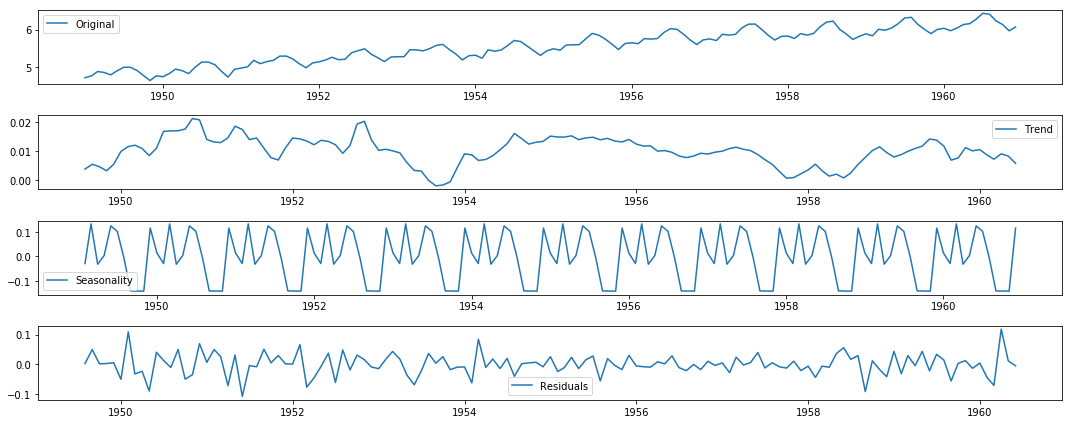

In [28]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Now that the trend and seasonality has been removed, the residuals can be analysed for stationarity.

In [29]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

In [30]:
augmented_dickey_fuller(ts_log_decompose)

Test Statistic                -6.745773e+00
p-value                        3.037861e-09
#Lags Used                     1.300000e+01
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64

99% confidence for stationarity of the residuals

# Forecasting

Using the difference model to eliminate trend and seasonality as adding them back to the predicted residuals is relatively easier than other methods. We may be left with two situations:

1. A strictly stationary series with no dependence among the values.
2. A series with significant dependence among the values. (Statistical models are required to forecast)

We will be using the Auto Regressive Integrated Moving Averages (ARIMA) Model. The model is similiar to linear regression with the following parameters:

1. Number of AR (Auto-Regressive) Terms (p)
2. Number of MA (Moving Average) terms (q)
3. Number of Differences (d)

## ACF and PACF

In order to determine the values of p and q, we have to compute the following terms:

1. Auto-correlation Function (ACF): Measure of co-relation of a time series with a lagged version of itself.
2. Partial Auto-correlation Function (PACF): ACF but after eliminating the variations already explained by previous successive lags.

In [31]:
from statsmodels.tsa.stattools import acf, pacf

In [32]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

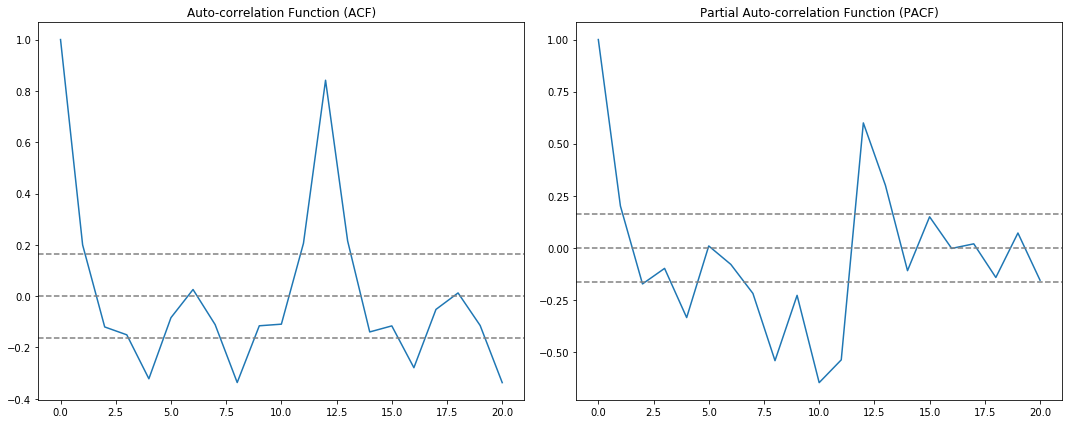

In [33]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Auto-correlation Function (ACF)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Auto-correlation Function (PACF)')
plt.tight_layout()

The two dotted lines on the either side of zero are confidence intervals that can be used to determine values for p and q.

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

## ARIMA Model

We will prepare 3 different models considering the individual as well as the combined effects. <br/>

Note: RSS printed is for the residuals and not for the actual series

In [34]:
from statsmodels.tsa.arima_model import ARIMA

The parameters required for the ARIMA model can be filled in a tuple in the order (p,d,q)

### Case 1: AR Model

D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

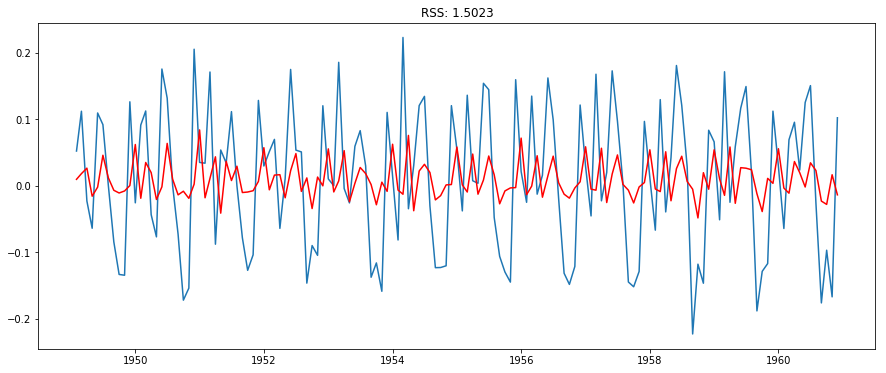

In [35]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### Case 2: MA Model

D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

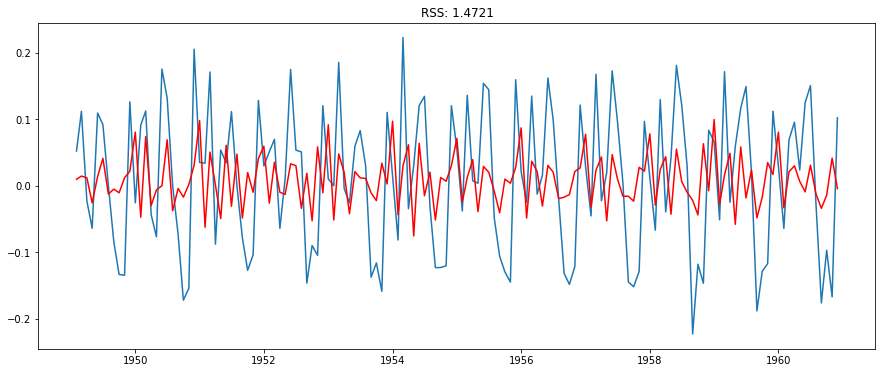

In [36]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Case 3: Combined Model

D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Mayank\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.9832')

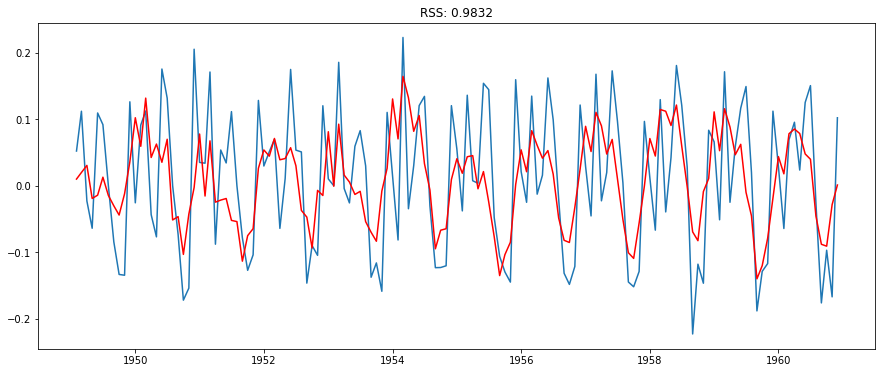

In [37]:
model = ARIMA(ts_log, order=(3, 1, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

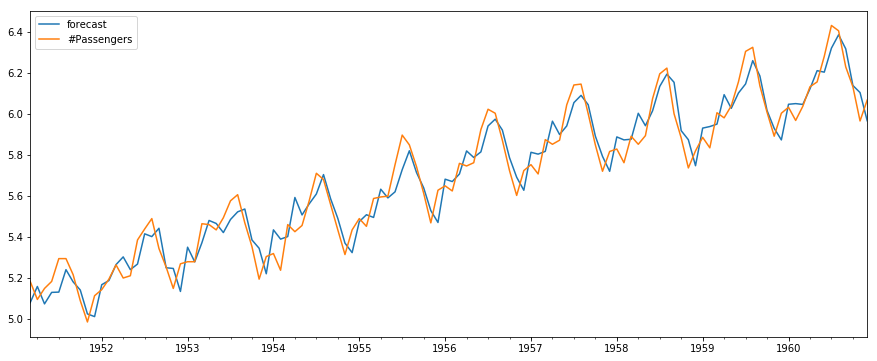

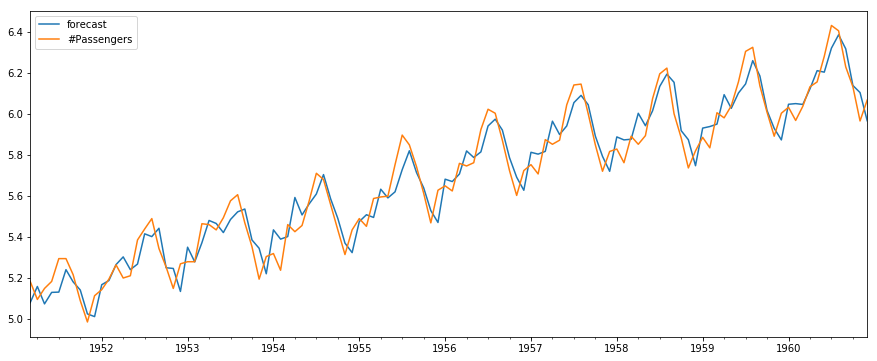

In [38]:
results_ARIMA.plot_predict(26)

Inference: The AR and MA models are almost the same, however the combined model has performed better with a relatively low RSS.

# Restoring to Original Scale

Continuing with the combined model, we scale it back to the original values. First, we store the predicted results as a separate series.

In [39]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009990
1949-03-01    0.019911
1949-04-01    0.030570
1949-05-01   -0.019166
1949-06-01   -0.014229
dtype: float64

Note: The dates start from the second month, since we took a lag of 1 month while differencing, there were no previous values to subtract from.

The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. 

In [40]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009990
1949-03-01    0.029901
1949-04-01    0.060471
1949-05-01    0.041306
1949-06-01    0.027076
dtype: float64

In [41]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

D:\Mayank\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728489
1949-03-01    4.748400
1949-04-01    4.778970
1949-05-01    4.759804
dtype: float64

Last step is to take the exponent and compare with the original series.

In [42]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 81.6673')

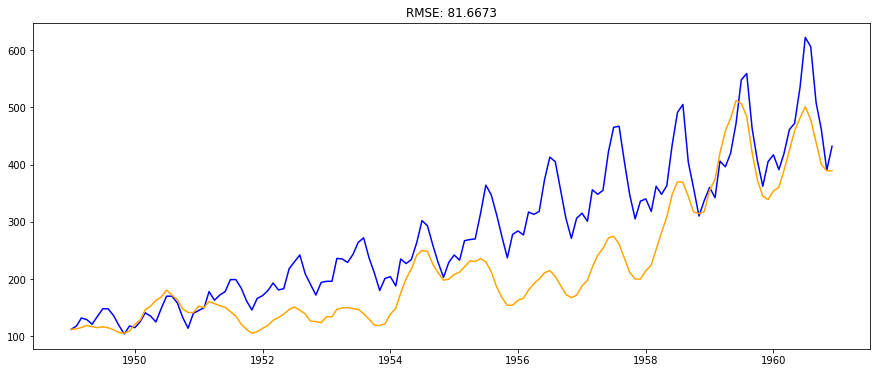

In [43]:
plt.plot(ts, color='blue')
plt.plot(predictions_ARIMA, color='orange')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

## Auto Arima Model

In [44]:
import warnings
import itertools
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [45]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
rmse=[]
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(disp=-1)

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
            #data_p=data.tail(131)
            predicted=results.fittedvalues
            rmse.append(sqrt(mean_squared_error(data, predicted)))
        except:
            continue          

Here we are selecting min value of Aic for best model Building

In [46]:
#Using p,d,q in ARIMA Model
mod = sm.tsa.statespace.SARIMAX(ts_log,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                #order=(1,0,1),
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                #seasonal_order=(2,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
predicted=results.fittedvalues
print(results.summary().tables[1])
#print(sqrt(mean_squared_error(data, predicted)))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.108      0.000       0.865       1.019
ma.L1         -0.3804      0.093     -4.094      0.000      -0.563      -0.198
ar.S.L12       1.0200      0.003    302.372      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.241      0.000       0.001       0.002


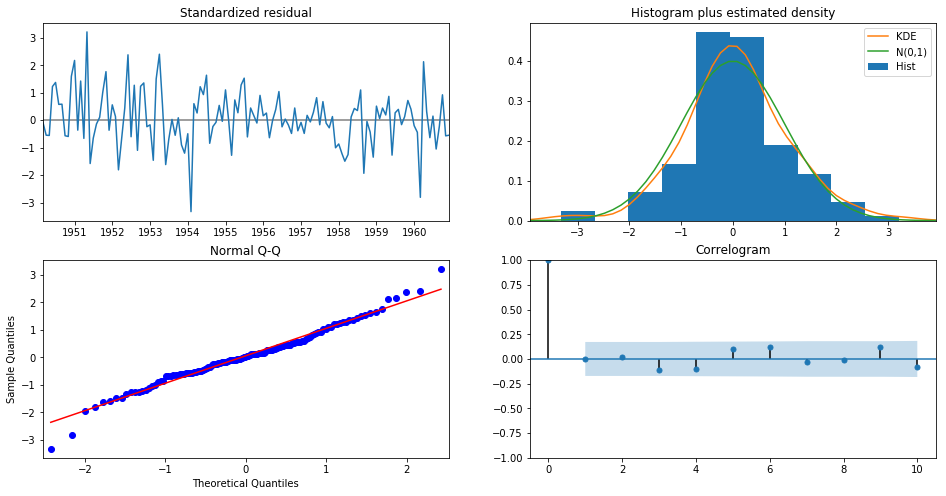

In [47]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

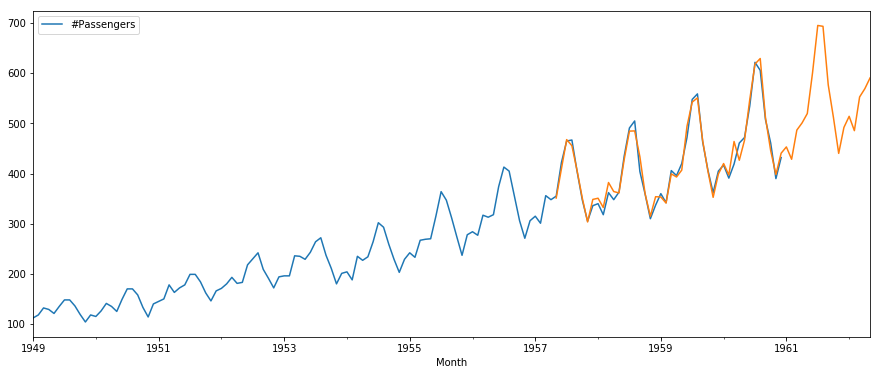

In [48]:
yhat = results.predict(100,160)
data.plot(figsize=(15, 6))
np.exp(yhat).plot(figsize=(15, 6))

In [ ]:
*************************************************The End***********************************************